In [12]:
import numpy as np
import pandas as pd
import glob as gl
import os
import time

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.tree import export_graphviz
""" from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from six import StringIO
import pydotplus """

' from IPython.display import Image\nfrom sklearn.ensemble import RandomForestClassifier\nfrom six import StringIO\nimport pydotplus '

In [13]:
path = "src/results"

""" datetime = "/2011-03-24_15"
df = pd.read_csv(path + datetime + '.csv')  """


dfs = []

for file in gl.glob(path + '/20*.csv'):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
#df.count() #cada csv tiene 160920 filas

## Label Encoder

In [14]:
modelo = df.iloc[:, 8].values 
modelo = LabelEncoder().fit_transform(modelo) #codificación del modelo

In [15]:
datetime = df.iloc[:, 14].values 
datetime = LabelEncoder().fit_transform(datetime) #codificación del datetime

In [16]:
df = df.drop(df.columns[[8, 14]], axis=1) #se eliminan las antiguas con los strings del modelo y datetime
df['modelo'] = modelo #se añade la nueva codificada al final
df['datetime'] = datetime #se añade la nueva codificada al final

X = df.iloc[:, 1:] 
X = X.drop(['timestamp', 'load', 'DC Array Output (W)', 'Pavg', 'dif', 'h'], axis=1)
y = df.iloc[:, 0].values #valores de overflow
X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo', 'datetime'],
      dtype='object')

In [6]:
########
# Mejores features : ['cap', 'dist', 'origen_id', 'dest_id', 
# 'len_origen_tag', 'len_dest_tag', 'total_balance', 'abs_flux'],

X = X.drop(['criterion', 'degree','Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'], axis=1)

X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'total_balance', 'abs_flux', 'datetime'],
      dtype='object')

## Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = StandardScaler() #escalado de datos
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## PCA

In [34]:
pca = PCA(n_components=2)
#pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Text(0, 0.5, 'Varianza (%)')

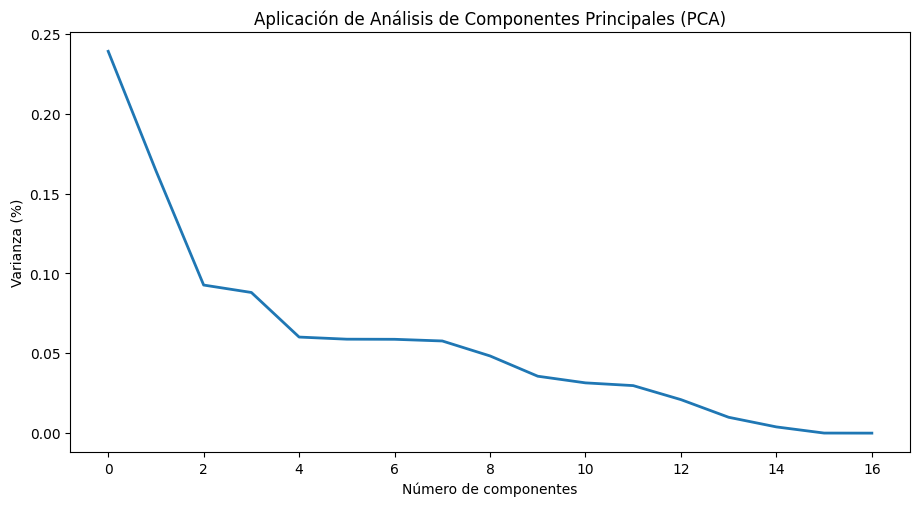

In [26]:
#Elbow Method

plt.figure(1, figsize=(12, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2) #Percentage of variance explained by each of the selected components.
plt.axis('tight')
plt.xlabel('Número de componentes')
plt.title('Aplicación de Análisis de Componentes Principales (PCA)')
plt.ylabel('Varianza (%)')

##  Univariate feature selection

In [22]:
scaler = MinMaxScaler() # Escalar las características al rango [0, 1]

#5 features para probar, despues de ejecutasr rfecv se utiliza k=8 que ese el nº óptimo
#select_feature = SelectKBest(chi2, k=5).fit(scaler.fit_transform(X_train), y_train) 
select_feature = SelectKBest(chi2, k=8).fit(scaler.fit_transform(X_train), y_train) 
selected_features = X.columns[select_feature.get_support(indices=True)]

print('Selected features:', selected_features)

Selected features: Index(['cap', 'len_origen_tag', 'len_dest_tag', 'Beam Irradiance (W/m2)',
       'Plane of Array Irradiance (W/m2)'],
      dtype='object')


In [23]:
X_train_fs = select_feature.transform(X_train)
X_test_fs = select_feature.transform(X_test)

## Random Forest

In [24]:
inicl = time.time()

classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 0) #estimators = trees

#42.5seg, 26.94seg (10 estimadores sin)
#64.379seg (25 estimadores sin)
#132.05seg (50 estimadores sin y RFECV)
#193.83seg (75 estimadores sin)
#223.597seg (85 estimadores sin)
#433.65seg (100 estimadores sin)
#529.88seg, 466.61seg (200 estimadores sin y RFECV)
#classifier.fit(X_train, y_train)
#classifier.fit(X_train_pca, y_train) #145.77seg
classifier.fit(X_train_fs, y_train) #30.41seg

fincl = time.time()
print(fincl-inicl) 

63.62988758087158


### Evaluación de features (classifier sin aplicar PCA o FS)

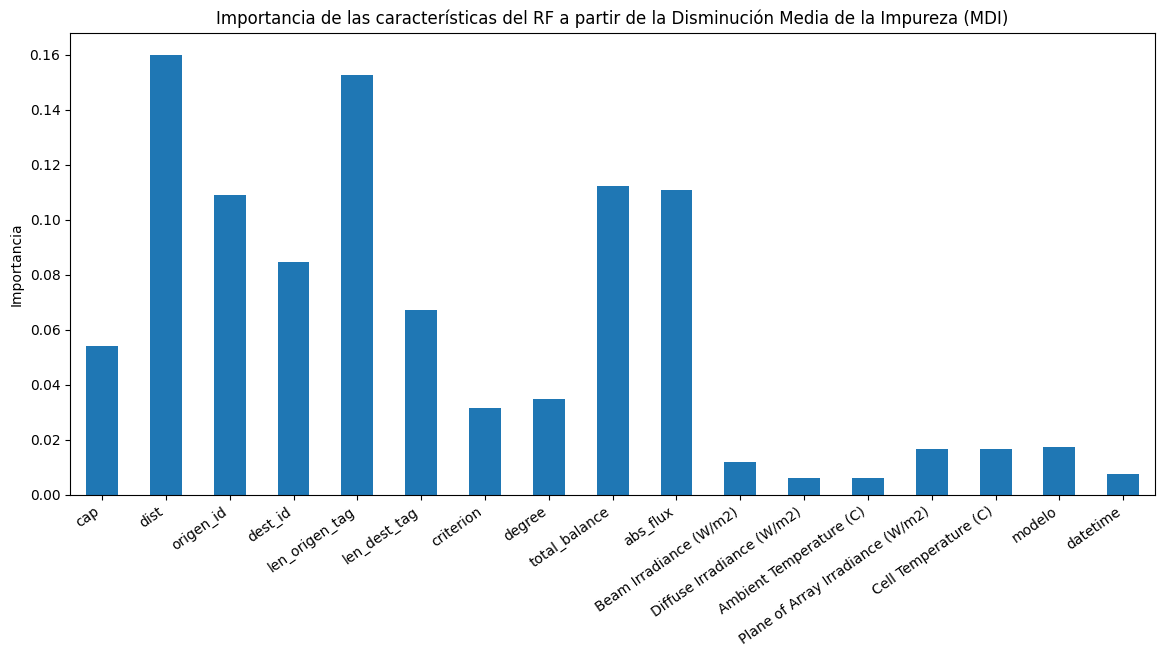

In [9]:
# Feature importance based on mean decrease in impurity

features_ranking = pd.Series(classifier.feature_importances_, index=X.columns)

plt.figure(figsize=(12, 6))  
features_ranking.plot(kind='bar')
plt.ylabel('Importancia')
plt.title('Importancia de las características del RF a partir de la Disminución Media de la Impureza (MDI)')
plt.xticks(rotation=35, ha='right')
plt.show()

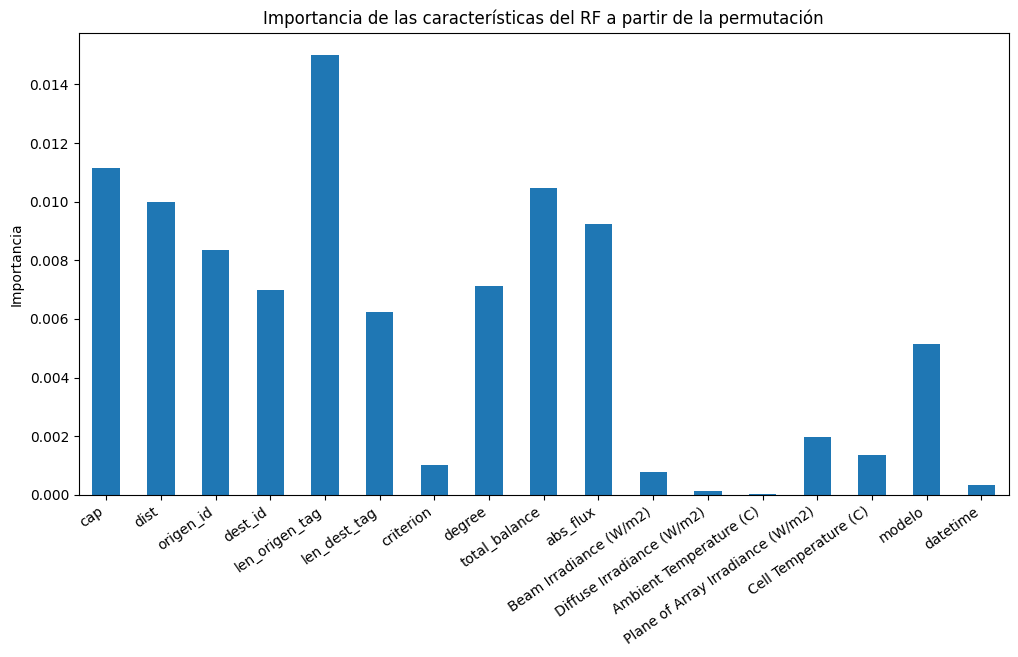

In [10]:
# Feature importance based on feature permutation

result = permutation_importance(
    classifier, X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
)

importances_mean_series = pd.Series(result.importances_mean, index=X.columns)

plt.figure(figsize=(12, 6))
importances_mean_series.plot(kind='bar')
plt.ylabel('Importancia')
plt.title('Importancia de las características del RF a partir de la permutación')
plt.xticks(rotation=35, ha='right')
plt.show()

### Recursive feature elimination with cross validation (classifier sin aplicar PCA o FS)

In [10]:
# The "accuracy" scoring is proportional to the number of correct classifications
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html 
# Now we will not only find best features but we also find how many features do we need for best accuracy.

rfecv = RFECV(estimator=classifier, step=1, cv=5, scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Nº óptimo de features :', rfecv.n_features_)
print('Mejores features :', X.columns[rfecv.support_])

# Nº óptimo de features : 8
# Mejores features : ['cap', 'dist', 'origen_id', 'dest_id', 
# 'len_origen_tag', 'len_dest_tag', 'total_balance', 'abs_flux'],

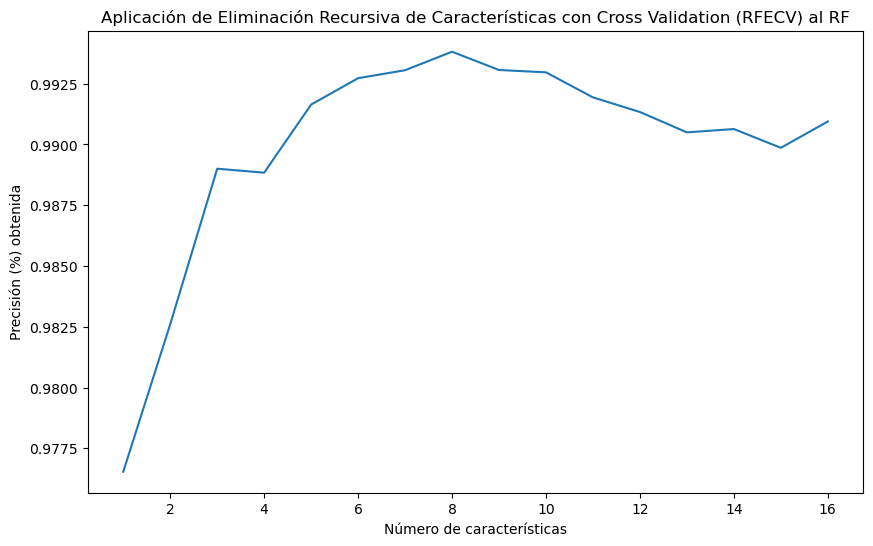

In [23]:
plt.figure(1, figsize=(10, 6))
plt.xlabel("Número de características")
plt.ylabel("Precisión (%) obtenida")
plt.title("Aplicación de Eliminación Recursiva de Características con Cross Validation (RFECV) al RF")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

## Evaluación

### Matriz de confusión

In [25]:
#y_pred = classifier.predict(X_test)
#y_pred = classifier.predict(X_test_pca)
y_pred = classifier.predict(X_test_fs)

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

#10 estimadores
#0.9912896677438064 || [[376752    392] [  2972   6092]] sin 
#0.9752335529041346 || [[376593    551] [  9014     50]] con PCA (2)
#0.9764194423730218 || [[376965    179] [  8928    136]] con PCA (3)
#0.9779497058579832 || [[376555    589] [  7927   1137]] con Feature Selection (5)
#0.9773153326704781 || [[374986   2158] [  6603   2461]] con Feature Selection (8)
#0.9944485872897506 || [[376718    426] [  1718   7346]] con RFECV (8)


#25 estimadores
#0.9929286809180545 || [[376745    399] [  2332   6732]] sin 
#0.9755856947551579 || [[376718    426] [  9003     61]] con PCA (2)
#0.9806451445853012 || [[376684    460] [  7015   2049]] con PCA (4)
#0.9944019802800563 || [[376699    445] [  1717   7347]] con RFECV (8)
#0.9779497058579832 || [[376555    589] [  7927   1137]] con Feature Selection (5)
#0.9774732786477753 || [[375027   2117] [  6583   2481]] con Feature Selection (8) 


#50 estimadores 
#0.9930866268953518 || [[376811    333] [  2337   6727]] sin
#0.9951140318170519 || [[376722    422] [  1465   7599]] con RFECV (8)


#75 estimadores
#0.9932575192642307 || [[376813    331] [  2273   6791]] sin


#100 estimadores 
#0.9932756442124451 || [[376826    318] [  2279   6785]] sin
#0.9862043251304996 || [[376864    280] [  5048   4016]] con PCA (2)
#0.9872944113016819 || [[377073     71] [  4836   4228]] con PCA (3)
#0.995173585218328  || [[376721    423] [  1441   7623]] con RFECV (8)


#200 estimadores
#0.9933818046234154 || [[376830    314] [  2242   6822]] sin
#0.9952616206810838 || [[376724    420] [  1410   7654]] con RFECV (8)                                                 con RFECV (8)

[[376555    589]
 [  7927   1137]]


0.9779497058579832

### K-Fold

In [ ]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
#accuracies = cross_val_score(estimator = classifier, X = X_train_pca, y = y_train, cv = 5)
#accuracies = cross_val_score(estimator = classifier, X = X_train_fs, y = y_train, cv = 5)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100)) 

#10 estimadores
#Accuracy: 99.09 % Standard Deviation: 0.02 % sin 
#Accuracy: 97.54 % Standard Deviation: 0.01 % con PCA (2)
#Accuracy: 97.63 % Standard Deviation: 0.00 % con PCA (3)
#Accuracy: 97.79 % Standard Deviation: 0.02 % con Feature Selection (5)
#Accuracy: 97.69 % Standard Deviation: 0.01 % con Feature Selection (8)
#Accuracy: 99.41 % Standard Deviation: 0.02 % con RFECV (8)

#25 estimadores
#con PCA (2)
#Accuracy: 98.04 % Standard Deviation: 0.01 % con PCA (4)

#100 estimadores
#Accuracy: 98.58 % Standard Deviation: 0.02 % con PCA (2)
#Accuracy: 98.68 % Standard Deviation: 0.02 % con PCA (3)

## Figuras 

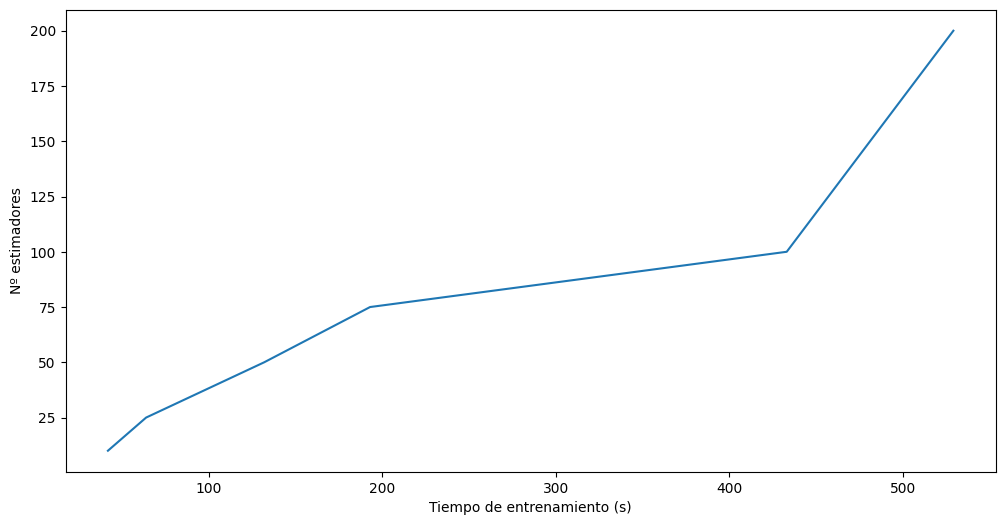

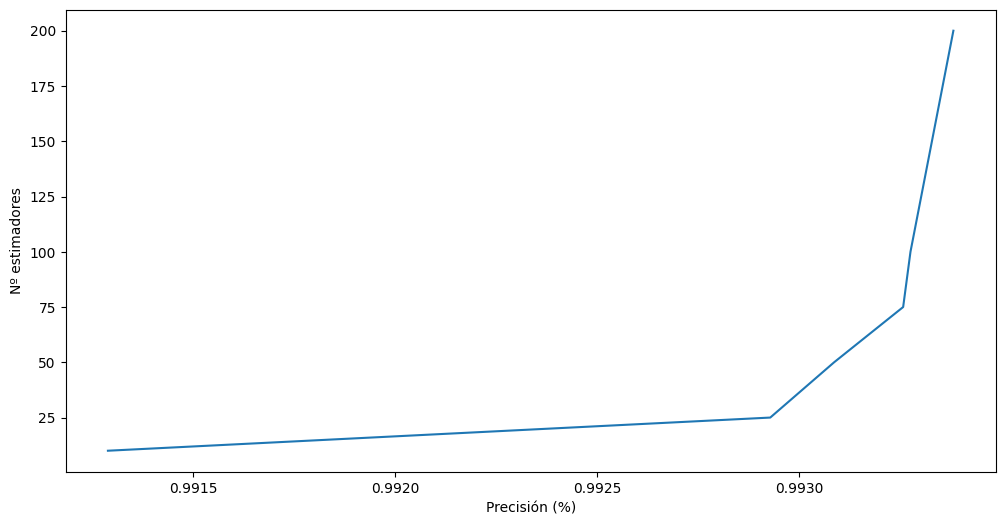

In [45]:
estimators = [10, 25, 50, 75, 100, 200]
tiempos = [42, 64, 132, 193, 433, 529]
accuracy = [0.9912896677438064, 0.9929286809180545, 0.9930866268953518, 0.9932575192642307, 0.9932756442124451, 0.9933818046234154]

plt.figure(figsize=(12, 6))
plt.plot(tiempos, estimators)
plt.ylabel('Nº estimadores')
plt.xlabel('Tiempo de entrenamiento (s)')
plt.title('')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(accuracy, estimators)
plt.ylabel('Nº estimadores')
plt.xlabel('Precisión (%)')
plt.title('')
plt.show()

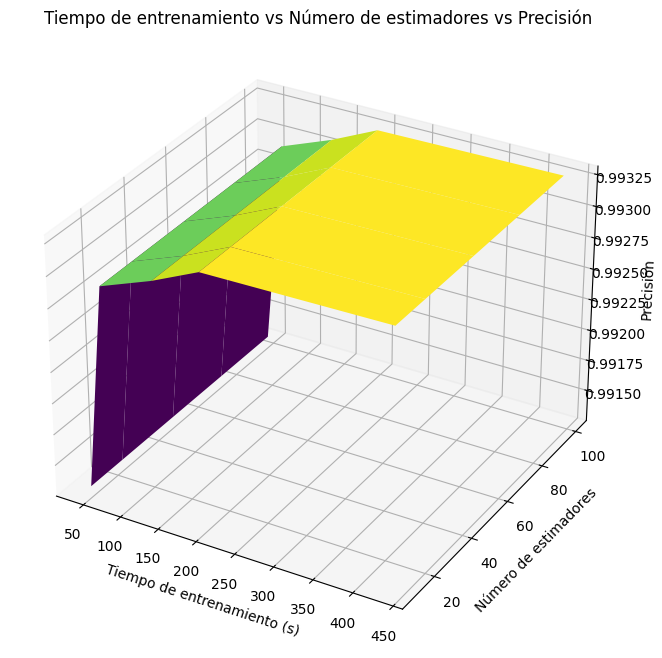

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#estimators = [10, 25, 40, 50, 75, 85, 100]
#tiempos = [42, 64, 105, 132, 193, 223, 433]

estimators = [10, 25, 50, 75, 100]
tiempos = [42, 64, 132, 193, 433]
accuracy = [0.9912896677438064, 0.9929286809180545, 0.9930866268953518, 0.9932575192642307, 0.9932756442124451]

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(tiempos, estimators)
Z = np.array([accuracy] * len(tiempos))
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Tiempo de entrenamiento (s)')
ax.set_ylabel('Número de estimadores')
ax.set_zlabel('Precisión')
ax.set_title('Tiempo de entrenamiento vs Número de estimadores vs Precisión')

plt.show()

In [37]:
for i, tree in enumerate(classifier.estimators_):
    dot = export_graphviz(tree,
                        feature_names=X.columns,  
                        filled=True,  
                        max_depth=4, 
                        impurity=False, 
                        proportion=True)
    
    dot_name = f"tree_{i}.dot"
    with open(dot_name, "w") as f:
        f.write(dot)

    os.system(f"dot -Tpng {dot_name} -o") #ver en http://www.webgraphviz.com/

In [38]:
X_set, y_set = X_train, y_train
X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

## Grid Search

### Estimación de tiempos

In [8]:
parameters = {
    #'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
    'n_estimators': [10, 25, 50, 75, 100],
    'criterion': ['entropy', 'gini']
    }

#https://datascience.stackexchange.com/questions/29495/how-to-estimate-gridsearchcv-computing-time

processors = 32
cv = 5 
combos = 1

for j in parameters.values():
    combos *= len(j)

num_models = combos * cv / processors 
seconds = num_models * (fincl-inicl)
minutes = seconds / 60
hours = minutes / 60

print("{:.6f}".format(hours), "| {:.6f}".format(minutes), "| {:.6f}".format(seconds)) 
#0.081282 | 4.876910 | 292.614584 (1-15)
#0.021675 | 1.300509 | 78.030556 (20-50) esta!!

0.012610 | 0.756597 | 45.395806


### Ejecución

In [9]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters) 

print(grid_search.best_estimator_)
print(grid_search.cv_results_) #tabla de resultados
#Best Accuracy: 99.18 %, Best Parameters: {'criterion': 'gini', 'n_estimators': 15} 
#Best Accuracy: 99.23 %, Best Parameters: {'criterion': 'entropy', 'n_estimators': 50}
#Best Accuracy: 99.18 %, Best Parameters: {'criterion': 'entropy', 'n_estimators': 100}



# RandomForestClassifier(criterion='entropy', random_state=0)
# {'mean_fit_time': array([ 147.23916469,  373.31760321,  747.21636357, 1072.7543149 , 1439.3701149 ,  146.76576381,  382.60065813,  761.48868456, 1002.00803509,  987.47603831]), 
#  'std_fit_time': array([11.00769272, 14.11245022, 30.6479004 , 34.73596408, 20.46197249, 3.38427574, 11.63971586, 32.67837982, 62.37159869, 33.82452456]), 
#  'mean_score_time': array([ 3.24913354,  7.07156687, 15.12688808, 21.45082655, 30.03672585, 3.05407963,  7.21116533, 16.20404158, 14.21989012,  8.98553667]), 
#  'std_score_time': array([0.39418355, 1.44465571, 2.01443514, 2.28704795, 1.21166409, 0.3512997 , 0.89531714, 1.61616145, 3.10780965, 1.45551608]), 
 
#  'params': [{'criterion': 'entropy', 'n_estimators': 10}, 
#             {'criterion': 'entropy', 'n_estimators': 25}, 
#             {'criterion': 'entropy', 'n_estimators': 50}, 
#             {'criterion': 'entropy', 'n_estimators': 75}, 
#             {'criterion': 'entropy', 'n_estimators': 100}, 
#             {'criterion': 'gini', 'n_estimators': 10}, 
#             {'criterion': 'gini', 'n_estimators': 25}, 
#             {'criterion': 'gini', 'n_estimators': 50},
#             {'criterion': 'gini', 'n_estimators': 75}, 
#             {'criterion': 'gini', 'n_estimators': 100}], 

#  'split0_test_score': array([0.99094725, 0.99161399, 0.99172727, 0.99183084, 0.99185674, 0.99009927, 0.9912871 , 0.99150071, 0.99170138, 0.99157839]), 
#  'split1_test_score': array([0.99044882, 0.9914198 , 0.99146511, 0.99152984, 0.99164636, 0.99031935, 0.99125797, 0.99158163, 0.99158486, 0.99151689]), 
#  'split2_test_score': array([0.99069153, 0.99171754, 0.99166575, 0.99183405, 0.99182111, 0.99038406, 0.99163338, 0.99162691, 0.99188908, 0.99185671]), 
#  'split3_test_score': array([0.99061385, 0.9916528 , 0.99174666, 0.99193439, 0.99189555, 0.99035169, 0.99141006, 0.99165928, 0.99177256, 0.99175314]), 
#  'split4_test_score': array([0.99082423, 0.99174666, 0.99173048, 0.99184053, 0.99185024, 0.99029019, 0.99150068, 0.99153952, 0.99174666, 0.99171754]),

#  'mean_test_score': array([0.99070514, 0.99163016, 0.99166706, 0.99179393, 0.991814, 0.99028891, 0.99141784, 0.99158161, 0.99173891, 0.99168453]), 
#  'std_test_score': array([1.71476642e-04, 1.15095689e-04, 1.04662350e-04, 1.37561331e-04, 8.71139088e-05, 9.98870333e-05, 1.38590322e-04, 5.72718568e-05, 9.88749511e-05, 1.22319314e-04]), 
#  'rank_test_score': array([ 9,  6,  5,  2,  1, 10,  8,  7,  3,  4])}

Best Accuracy: 99.18 %
Best Parameters: {'criterion': 'entropy', 'n_estimators': 100}
RandomForestClassifier(criterion='entropy', random_state=0)
{'mean_fit_time': array([ 147.23916469,  373.31760321,  747.21636357, 1072.7543149 ,
       1439.3701149 ,  146.76576381,  382.60065813,  761.48868456,
       1002.00803509,  987.47603831]), 'std_fit_time': array([11.00769272, 14.11245022, 30.6479004 , 34.73596408, 20.46197249,
        3.38427574, 11.63971586, 32.67837982, 62.37159869, 33.82452456]), 'mean_score_time': array([ 3.24913354,  7.07156687, 15.12688808, 21.45082655, 30.03672585,
        3.05407963,  7.21116533, 16.20404158, 14.21989012,  8.98553667]), 'std_score_time': array([0.39418355, 1.44465571, 2.01443514, 2.28704795, 1.21166409,
       0.3512997 , 0.89531714, 1.61616145, 3.10780965, 1.45551608]), 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                   'gini', 'gini', 'gini', 'gini', 'gini'],
             mask=[False, Fal